<a href="https://colab.research.google.com/github/cruxbots/An-apple-a-Day/blob/main/apple_a_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***An apple a day keeps a doctor away [Using U-net]***


> The main aim of this model is to count the total numbers of Apples in an particular image. But, this model does something extra, It's not only capable of counting apples but also capable to check that the apples you are gonna eat are in good condition if trained, but due to time restrictions i was not able to do this.

> It does so by outputing the binary image of the input image in which there are two classes that are *APPLEs* and *NOT Apples*. One more distinctive feauture of this model is that, unlike traditional object detection models it does semantic segmentation that is it dosen't only outputs certain paramenters related to apples but the output of this model is *EACH AND EVERY PIXEL IN THE IMAGE AS EITHER CLASS APPLE OR NOT APPLE*. 

> This model has many advantages over other it can be also used for navigation if the camera is installed on a mobile robot. Many of the pros are already discussed above and many more are added in here. Since unet was originally made for biomedical imaging it requires significantly less amount of data to give an output, because it mostly depended upon the image augmentation. 

> One of the problem with this model is *YELLOW LEAFES* this recognise them as apples.

> So, i think this model is going to be very good.


**References to websites that was used for coding this projects:**

1.   https://www.kaggle.com/kmader/vgg16-u-net-on-carvana
2.   https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336
3.   https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336
4.   https://nanonets.com/blog/how-to-do-semantic-segmentation-using-deep-learning/
5.   https://missinglink.ai/guides/tensorflow/tensorflow-image-segmentation-two-quick-tutorials/
6.   https://www.youtube.com/watch?v=qFJeN9V1ZsI&t=9106s

## **Importing important libraries and mounting drive**


**This is pretty straightforward thing to do and dosen't need any explaination**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import keras
from PIL import ImageOps,Image
import os

# **Creating labels and training images**

**In this section we intent to create labels and  images which can be used for further trainings**



## Data acquisition

Get images and masks from the drive 

### Initiating all the variables

In [ ]:
#@title Default title text
#For locating files for DataGenerator Method
dg_img_location = "/content/drive/MyDrive/apple_a_day/image"                      # Acces files for training
dg_mask_location = "/content/drive/MyDrive/apple_a_day/mask/"

dg_test_img_location = "/content/drive/MyDrive/apple_a_day/test_image"            # Acces files for testing
dg_test_mask_location = "/content/drive/MyDrive/apple_a_day/test_mask"

dg_val_img_location = "/content/drive/MyDrive/apple_a_day/val_image"              # Acess files for validation
dg_val_mask_location = "/content/drive/MyDrive/apple_a_day/val_mask"

Batch_size = 30                                                                   #batch size of training data
size_x = 640                                                                      # sizes of input images
size_y = 352


### Function for mask preprocessing

>This function is used to preprocess mask image Since image is in format (size_x,size_y,1) it is better to convert into PIL using tf. 

>Mask that is being used here has varying values [0-255] for apples thats needs to be chnaged to 1 {1--> APPLE and 0--> backgroung} 

In [ ]:
def mask_preprocessing(mask):
              
              mask = tf.keras.preprocessing.image.array_to_img(mask)              #convert array type to PIL type
              mask = mask.point(lambda p: p > 10 and 1)                           # thresholding image { If any thing greater than 10 make it 1}
              mask = tf.keras.preprocessing.image.img_to_array(mask)              # PIL --> array
              mask = tf.convert_to_tensor(mask, dtype=np.float32)                 # convert to Tensor object
              return mask                                                         


### Creating labels and images using ImageDatagenerator

We are using ImageDataGenerator function in tf to preprocess and generate trainaible data in here section

>**Reason to use specific arguments in the function since was difficult to comment**

>Since data shuffle is true ( to increasing uncertainity and to avoid underfitting) *Seed* is used to ensure that both of them outputs in sync

> *class_mode & classes* are set to none because we don't need classes in output

> *samplewise_std_normalization* is used to standardise the data to avoid undefiting it just divides pixel value by a standard of all the images in datasets We don't want to do this mask labels


In [ ]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_std_normalization=True)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function= mask_preprocessing)


image_generator = image_datagen.flow_from_directory(directory=dg_img_location                                           
                                                    , target_size=(size_x,size_y)
                                                    , seed=42  
                                                    , class_mode=None                                           
                                                    , classes=None
                                                    , batch_size=Batch_size)
mask_generator = mask_datagen.flow_from_directory(directory=dg_mask_location
                                                  ,target_size=(size_x,size_y)
                                                  , color_mode="grayscale"
                                                  , seed=42
                                                  , class_mode=None
                                                  , classes=None
                                                  , batch_size=Batch_size)

train_generator = zip(image_generator, mask_generator)                              # Zip it to create a stack having images and labels


test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_std_normalization=True).flow_from_directory(directory=dg_test_img_location
                                                           , target_size=(size_x,size_y)
                                                           , seed=42
                                                           ,class_mode=None
                                                           ,classes=None
                                                           , batch_size=Batch_size)
test_mask_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function= mask_preprocessing).flow_from_directory(directory=dg_test_mask_location
                                                                    ,target_size=(size_x,size_y)
                                                                    ,color_mode="grayscale"                 #to get mask image in greyscale (x,y,1)
                                                                    , seed=42
                                                                    ,class_mode=None
                                                                    , classes=None
                                                                    , batch_size=Batch_size)

test_generator      = zip(test_image_generator, test_mask_generator)

val_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mask_preprocessing) 


val_image_generator = val_image_datagen.flow_from_directory(directory=dg_val_img_location
                                                            , target_size=(size_x,size_y)
                                                            , class_mode=None
                                                            , classes=None
                                                            , shuffle=False)
val_mask_generator = val_mask_datagen.flow_from_directory(directory=dg_val_mask_location
                                                          ,target_size=(size_x,size_y)
                                                          , class_mode=None
                                                          , classes=None                                    #No greyscale image required since not converted to mask
                                                          , shuffle= False)                                 # we don't need to shuffle data here

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 47 images belonging to 1 classes.
Found 47 images belonging to 1 classes.
Found 12 images belonging to 1 classes.
Found 12 images belonging to 1 classes.
Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.


## Troubleshooting

In [ ]:
print(np.shape(mask_generator.next().astype(np.uint8)))       # Since generated data is not being stored this is used for troubleshooting

### Display the created data

In [ ]:
# This function is used to print first 10 images used for training
# first time you call this function you may get only 8 and second time you will get 10
def display(images_arr):                                                   
  fig, axes = plt.subplots(1, 10, figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

display(image_generator.next().astype(np.uint8))

Display the 1st image in each of the generator

In [ ]:
# This is more practical it calls only the desired image and mask from test and training dataset
plt.imshow(image_generator.next().astype(np.uint8)[0])
plt.show()
plt.imshow(np.squeeze(mask_generator.next().astype(np.uint8)[0]))
plt.show()
plt.imshow(test_image_generator.next().astype(np.uint8)[0])
plt.show()
plt.imshow(np.squeeze(test_mask_generator.next().astype(np.uint8)[0]))
plt.show()

# **Creating Model**

**In these section we define our U-net model**

## creating downsampler

The channels are increased by twice the size and image dimensions are reduced by half that is downsampling or encoding this is done to know which class are there in the image Its decreased by half size to avoid information loss

In [ ]:
#We are using VGG16 as downsampler without training it and not including its dense layer neither its top layer
base_model = keras.applications.VGG16(weights="imagenet",include_top=False,input_shape=[size_x,size_y,3])

layer_names = [
    'block1_pool',         #640x368x64
    'block2_pool',         #320x184x128
    'block3_pool',         #160x92x256
    'block4_pool',         #80x46x512
    'block5_pool',         #40x23x512
]
layers = [base_model.get_layer(name).output for name in layer_names]          # Calling layers using list comprehension to make code cleaner

down_stack = tf.keras.Model(inputs = base_model.input, outputs = layers)      # Creating the downsampler model

down_stack.trainable = False                                                  # Thou shall not be trained

#base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step


## creating umpsampler

The function of downsampler is to increase the size of input image [Input from the downsampler(obviosly)]. This part of the model is responsible for localising object in an image

In [ ]:
#We are using parts of pix2pix as our upsampler. Here we are defining our upsampler layer that we will be calling in next cell layer. 
#To keep the code nice and clear!!!!
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()                                          # Adding Layers
  result.add(                                                             
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,             # Conv2dTranspose is exactly opposite of conv2d
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())                        #Normalization is included to avoid overfitting and less data is required

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.8))                          #Can be tweeked to increase performance 

  result.add(tf.keras.layers.ReLU())                                    #Relu layer is added as suggested in paper (Please refer report)

  return result

## **defining filters** to be used in upsampler

In [ ]:
#Note that same number of filters are used here as in downsampler its increment rate and decrement rates are same, Well that makes it U-net!!!!
up_stack = [
    upsample(512,3),        #40x23
    upsample(256,3),        #80x46
    upsample(128,3),        #160x92
    upsample(64,3),         #320x184
]


## **Defining UNET MODEL**

This is the part where we add upsampler and downsampler together to make our U-NET model. We want to concatenate two layers one in upsampler and other in downsampler.

In [ ]:
def unet_model(output_channels):
    
    inputs = tf.keras.layers.Input(shape=[size_x,size_y,3])
    x = inputs                                                  # Defining Input shape

    skips = down_stack(x)                                       # Calling downsampler
    x = skips[-1]     
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):                       # this for loop is called to concatenate the layers in both parts
        x = up(x)
        concat = tf.keras.layers.Concatenate()                  # function to concatenate layer (To check which layers are being concatenated check report)
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(output_channels, 2           #Defining the last layer activation is SIGMOID because we use BinaryCrossentropy
                                           ,strides=2, padding='same'   # Function of stride is to skip pixels in order to make learning fast
                                           , activation='sigmoid')      # Changing this will also change size and channels of image that is undesirable

    x = last(x)

    return tf.keras.Model(inputs = inputs, outputs = x)

## **compliling the model**

At this time we compile the model Since there are 2 classes and Binary Crossentropy is used we need 1 channel output that is what we do. 

In [ ]:
#LEARNING RATE can be tweeked to improve performance
#Metrics define what parameters we need in output to get the output of the model
model = unet_model(1)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True) , 
              metrics = ['accuracy','Precision','Recall'])

## plotting keras model

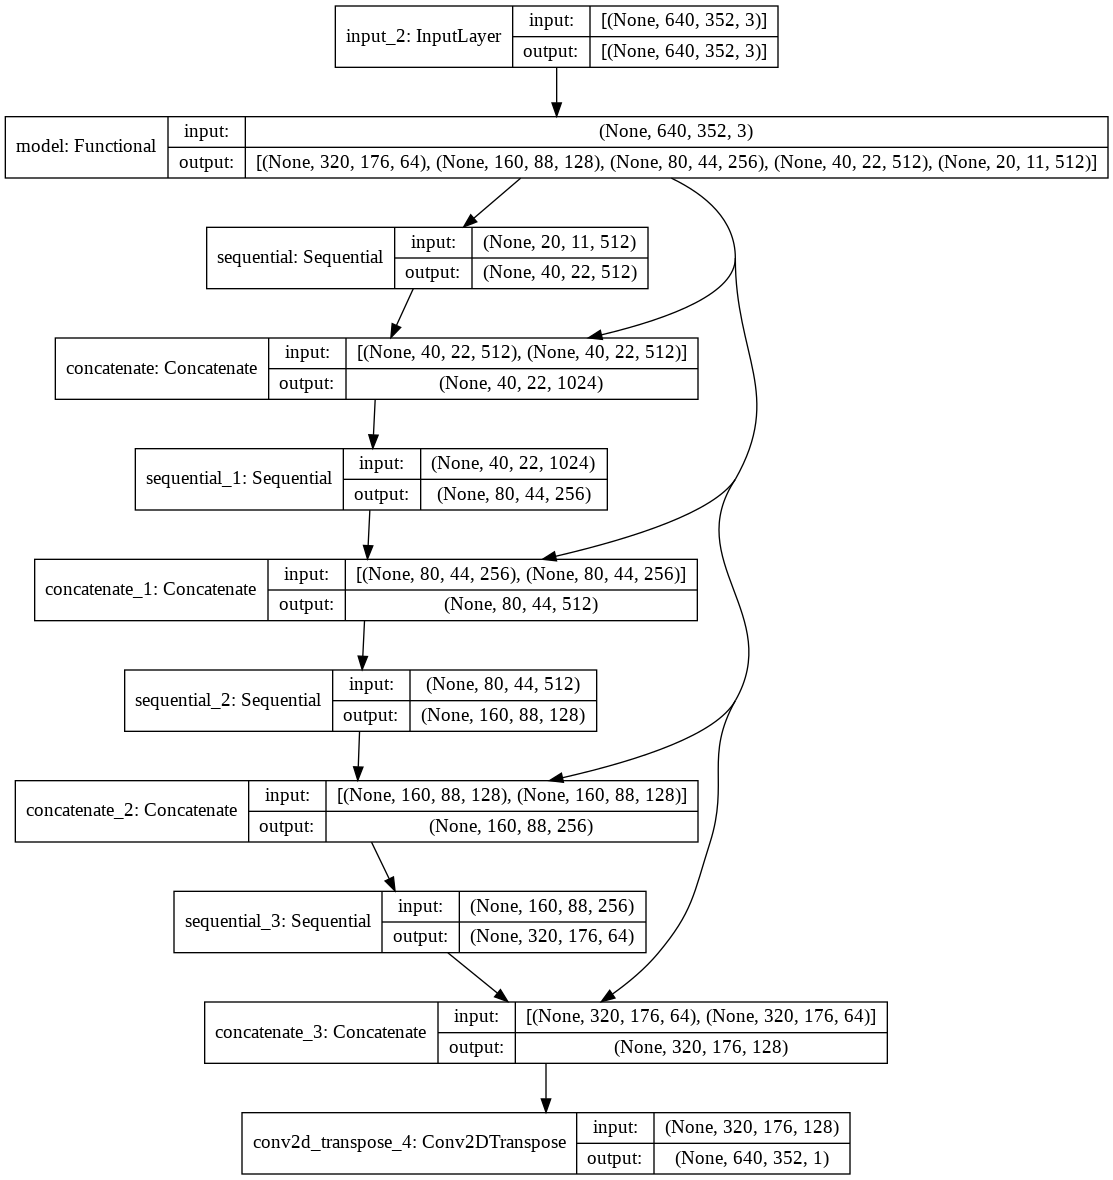

In [ ]:
from IPython.display import Image
tf.keras.utils.plot_model(model, show_shapes=True, to_file="apple_a_day_model.png")
#model.summary()
Image(retina=True,filename='apple_a_day_model.png')


# **Training the model** 

This is the most important step and hence most exiting part!!!! We input train_generator which has both training image and label (i.e mask) to check how good model is being trained that is ground truth we give the model test_generator having same elements as train_generator

In [ ]:
# Number of epochs is decided by looking at the graphs below
# steps_per_epoch = int(number of training image/batch size) didn't defined it in that way because want to experiment violeting that rule
# validation_steps = int(test image/ batch size) well can not make it zero!!!

period_of_time_defined_by_event = 50
model_history = model.fit(train_generator, epochs=period_of_time_defined_by_event, validation_data = test_generator, steps_per_epoch = 1, validation_steps=1)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.4221 - accuracy: 0.9591 - precision: 0.3235 - recall: 0.1324 - val_loss: 0.4123 - val_accuracy: 0.9475 - val_precision: 0.2068 - val_recall: 0.1626
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.4443 - accuracy: 0.9591 - precision: 0.4405 - recall: 0.1158 - val_loss: 0.3723 - val_accuracy: 0.9584 - val_precision: 0.3242 - val_recall: 0.1447
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.3333 - accuracy: 0.9697 - precision: 0.6468 - recall: 0.0929 - val_loss: 0.3418 - val_accuracy: 0.9638 - val_precision: 0.4862 - val_recall: 0.1310
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.3574 - accuracy: 0.9657 - precision: 0.7884 - recall: 0.0609 - val_loss: 0.3204 - val_accuracy: 0.9658 - val_precision: 0.6116 - val_recall: 0.1297
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.3657 - accuracy: 0.9631 - precision: 0.8913 - recall:

# **Results**

## Loss and Accuracy

This function is used to get epoch vs accuracy and loss graphs that is very usefull whit diagnossing overfitting underfitting and many more errors and could suggest any tweeking required in the model

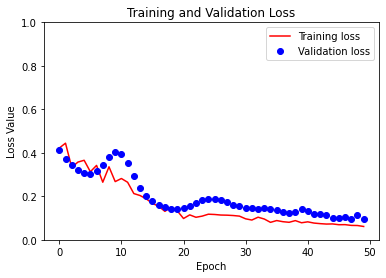

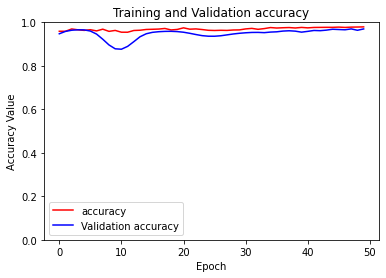

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

accu = model_history.history['accuracy']
val_accu = model_history.history['val_accuracy']

epochs = range(period_of_time_defined_by_event)

plt.figure()                                                      #To plot Epoch Vs Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


plt.figure()                                                    #To plot Epoch Vs Accuracy
plt.plot(epochs, accu, 'r', label='accuracy')
plt.plot(epochs, val_accu, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()

plt.show()

 ## Recall and Precision

This function is use to plot epoch vs recall and precision curve. Recall and Precision are task specific and whenever the graph shows that may suit the task the training should be stopped at that epoch

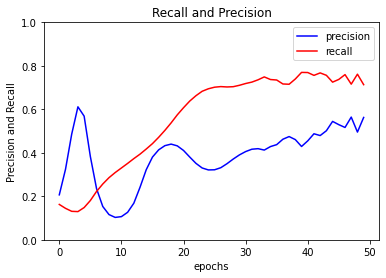

In [ ]:
Precision = model_history.history['val_precision']
Recall    = model_history.history['val_recall']

plt.figure()                                                    
plt.plot(epochs, Precision, 'b', label ='precision')
plt.plot(epochs, Recall, 'r', label ='recall')
plt.title('Recall and Precision')
plt.xlabel('epochs')
plt.ylabel('Precision and Recall')
plt.ylim([0, 1])
plt.legend()

plt.show()

## **Image Visualization**

This function makes the model predict from bunch of selected images for validation

1/1 [==============================] - 0s 334ms/step
1.0


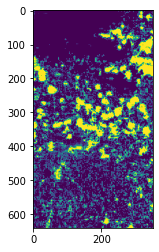

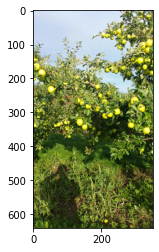

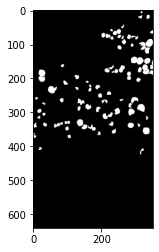

In [ ]:
pred_mask = model.predict(val_image_generator, verbose=1)                        # prediction using that model

print(np.max(pred_mask))                                      
i=0                                                                              # Select i to traverse through range of image

plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))              # show mask of predicted image looks cool in gray!!!
plt.show()


plt.imshow(val_image_generator.next().astype(np.uint8)[i])                       # Show validation image
plt.show()

                                     

plt.imshow(val_mask_generator.next().astype(np.uint8)[i]*255)       # Show validation mask
plt.show()

